In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as F
import sys
import seaborn as sns
plt.style.use('ggplot')

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df lecture") \
            .getOrCreate()
sc = spark.sparkContext

# Pull in artist feautures data

    -create spark df as df_artist_features

In [3]:
print(sys.path)

['/home/jovyan/work/Documents/dsi/Capstone1/notebooks', '/tmp/spark-104be6bd-001d-4faf-81f8-31a4e7f41065/userFiles-8c3c4964-5719-4cd9-8fa5-7eaa48f3a694', '/usr/local/spark/python/lib/py4j-0.10.9-src.zip', '/usr/local/spark/python', '/home/jovyan/work/Documents/dsi/Capstone1/notebooks', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/jovyan/.ipython']


In [4]:
dba = pd.read_csv('/home/jovyan/work/Documents/dsi/Capstone1/data/data_by_artist.csv')
dba.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7


In [5]:
df_artist_features = spark.read.csv('/home/jovyan/work/Documents/dsi/Capstone1/data/data_by_artist.csv',header=True).cache()
df_artist_features.printSchema()
print("line count: {}".format(df_artist_features.count()))
df_artist_features.show()

root
 |-- artists: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- count: string (nullable = true)

line count: 32539
+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+----+-----+
|             artists|       acousticness|       danceability|       duration_ms|             energy|    instrument

# Pull in million-playlist data

    -Playlist level data as df_playlistsdf_features

    -Track level data as df_tracks

In [6]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [7]:
million_list = spark.read.json('/home/jovyan/work/Documents/dsi/Capstone1/data/mpd.slice.0-999.json',multiLine=True).cache()

# prints the schema
million_list.printSchema()

# some functions are still valid
print("line count: {}".format(million_list.count()))

# show the table in a oh-so-nice format
million_list.show()

root
 |-- info: struct (nullable = true)
 |    |-- generated_on: string (nullable = true)
 |    |-- slice: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- playlists: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- collaborative: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- modified_at: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- num_albums: long (nullable = true)
 |    |    |-- num_artists: long (nullable = true)
 |    |    |-- num_edits: long (nullable = true)
 |    |    |-- num_followers: long (nullable = true)
 |    |    |-- num_tracks: long (nullable = true)
 |    |    |-- pid: long (nullable = true)
 |    |    |-- tracks: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album_name: string (nullable = true)
 |    |    |    |

In [8]:
million_list_lists = million_list.select("info", F.explode("playlists").alias('playlist'))
#million_exploded = million_list_lists.select("playlist", F.explode("playlist"))
million_list_lists.show()


+--------------------+--------------------+
|                info|            playlist|
+--------------------+--------------------+
|[2017-12-03 08:41...|[false,, 11532414...|
|[2017-12-03 08:41...|[false,, 11656470...|
|[2017-12-03 08:41...|[false,, 14039958...|
|[2017-12-03 08:41...|[false,, 28926058...|
|[2017-12-03 08:41...|[false,, 4335282,...|
|[2017-12-03 08:41...|[false,, 19156557...|
|[2017-12-03 08:41...|[false,, 3408479,...|
|[2017-12-03 08:41...|[false,, 12674796...|
|[2017-12-03 08:41...|[false,, 9948921,...|
|[2017-12-03 08:41...|[false,, 4297488,...|
|[2017-12-03 08:41...|[false,, 16403398...|
|[2017-12-03 08:41...|[false,, 35655891...|
|[2017-12-03 08:41...|[false,, 1981349,...|
|[2017-12-03 08:41...|[false,, 3039124,...|
|[2017-12-03 08:41...|[false,, 25837498...|
|[2017-12-03 08:41...|[false,, 1818256,...|
|[2017-12-03 08:41...|[false,, 24695913...|
|[2017-12-03 08:41...|[false,, 17627215...|
|[2017-12-03 08:41...|[false,, 15917464...|
|[2017-12-03 08:41...|[false,, 2

In [9]:
df_playlists = million_list_lists.select("playlist.*","*")
df_playlists.show()

+-------------+-----------+-----------+-----------+--------------------+----------+-----------+---------+-------------+----------+---+--------------------+--------------------+--------------------+
|collaborative|description|duration_ms|modified_at|                name|num_albums|num_artists|num_edits|num_followers|num_tracks|pid|              tracks|                info|            playlist|
+-------------+-----------+-----------+-----------+--------------------+----------+-----------+---------+-------------+----------+---+--------------------+--------------------+--------------------+
|        false|       null|   11532414| 1493424000|          Throwbacks|        47|         37|        6|            1|        52|  0|[[The Cookbook, s...|[2017-12-03 08:41...|[false,, 11532414...|
|        false|       null|   11656470| 1506556800|    Awesome Playlist|        23|         21|        5|            1|        39|  1|[[Eye Of The Tige...|[2017-12-03 08:41...|[false,, 11656470...|
|        f

In [10]:
million_exploded_song = df_playlists.select("collaborative","description","duration_ms","name","pid","num_followers",  F.explode("tracks").alias('tracks'))
playlist_tracks = million_exploded_song.select("tracks.*","*").withColumnRenamed("name","playlist_name") \
                                                                .withColumnRenamed("duration_ms","playlist_duration_ms") \
                                                                .withColumnRenamed("description","playlist_description") \
                                                                .withColumnRenamed("collaborative","playlist_collaborative") \
                                                                .withColumnRenamed("num_followers","playlist_followers") 
playlist_tracks.show()
print("line count: {}".format(playlist_tracks.count()))

+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+------------------+--------------------+
|          album_name|           album_uri|       artist_name|          artist_uri|playlist_duration_ms|pos|          track_name|           track_uri|playlist_collaborative|playlist_description|playlist_duration_ms|playlist_name|pid|playlist_followers|              tracks|
+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+------------------+--------------------+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|              226863|  0|Lose Control (fea...|spotify:track:0Ua...|                 false|     

In [11]:
df_tracks = playlist_tracks.drop('tracks')
df_tracks.show()

+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+------------------+
|          album_name|           album_uri|       artist_name|          artist_uri|playlist_duration_ms|pos|          track_name|           track_uri|playlist_collaborative|playlist_description|playlist_duration_ms|playlist_name|pid|playlist_followers|
+--------------------+--------------------+------------------+--------------------+--------------------+---+--------------------+--------------------+----------------------+--------------------+--------------------+-------------+---+------------------+
|        The Cookbook|spotify:album:6vV...|     Missy Elliott|spotify:artist:2w...|              226863|  0|Lose Control (fea...|spotify:track:0Ua...|                 false|                null|            11532414|   Throwbacks|  0|        

# Create temp table objects for SQL capabilities

In [12]:
df_playlists.createOrReplaceTempView("playlists")
df_tracks.createOrReplaceTempView("tracks")
df_artist_features.createOrReplaceTempView("artist_features")

# Exploratory Queries


## <font color='gray'> Playlist level data</font>

In [13]:
playlist_count = spark.sql("""
                           SELECT COUNT(pid)
                           FROM playlists
                           """)
playlist_count.show()

+----------+
|count(pid)|
+----------+
|      1000|
+----------+




## <font color='gray'> Tracks level data</font>

In [14]:
tracks_count_bytrack = spark.sql("""
                           SELECT artist_name
                           ,track_name
                           ,COUNT(*) AS count
                           FROM tracks
                           GROUP BY artist_name
                           ,track_name
                           ORDER BY count DESC
                           """)
tracks_count_bytrack.show()

+----------------+--------------------+-----+
|     artist_name|          track_name|count|
+----------------+--------------------+-----+
|           Drake|           One Dance|   55|
|  Kendrick Lamar|             HUMBLE.|   52|
|            DRAM|Broccoli (feat. L...|   50|
|The Chainsmokers|              Closer|   46|
|     Post Malone|     Congratulations|   44|
|The Chainsmokers|   Don't Let Me Down|   42|
|            KYLE|iSpy (feat. Lil Y...|   39|
|The Chainsmokers|               Roses|   39|
|        Big Sean|         Bounce Back|   39|
|           Drake|             Jumpman|   39|
|          Future|            Mask Off|   38|
|           Migos|Bad and Boujee (f...|   38|
|    Lil Uzi Vert|       XO TOUR Llif3|   37|
|     Post Malone|       White Iverson|   36|
|       Desiigner|               Panda|   36|
|           Aminé|            Caroline|   35|
|           Flume|   Never Be Like You|   35|
|   Justin Bieber|               Sorry|   35|
|    Travis Scott|          gooseb


## <font color='gray'> Features level data</font>

In [15]:
features_count = spark.sql("""
                            SELECT DISTINCT COUNT(artists) as count
                            FROM artist_features
                            """)
features_count.show()

+-----+
|count|
+-----+
|32539|
+-----+



# Creating playlist_features_join dataset

In [16]:
playlist_features_join = spark.sql("""
                                    SELECT t.artist_name
                                    ,t.pid
                                    ,t.pos
                                    ,t.playlist_name
                                    ,t.playlist_followers
                                    ,a.acousticness AS acousticness
                                    ,a.danceability AS danceability
                                    ,a.energy AS energy
                                    ,a.instrumentalness AS instrumentalness
                                    ,a.liveness AS liveness
                                    ,a.loudness AS loudness
                                    ,a.speechiness AS speechiness
                                    ,a.tempo AS avg_tempo
                                    ,a.valence AS valence
                                    ,a.popularity AS popularity
                                    FROM tracks t
                                    JOIN artist_features a
                                    ON t.artist_name = a.artists
                                    ORDER BY t.pid ASC, t.pos ASC
                                    """)
playlist_features_join.printSchema()
playlist_features_join.show()

root
 |-- artist_name: string (nullable = true)
 |-- pid: long (nullable = true)
 |-- pos: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_followers: long (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- avg_tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- popularity: string (nullable = true)

+------------------+---+---+-------------+------------------+-------------------+------------------+------------------+--------------------+-------------------+-------------------+--------------------+------------------+------------------+-----------------+
|       artist_name|pid|pos|playlist_name|playlist_followers|       acousticness|      danceability|            ene

In [17]:
aaa = spark.sql("""
                                    SELECT
                                    t.playlist_name
                                    ,AVG(t.playlist_followers)
                                    ,AVG(a.popularity) AS popularity
                                    FROM tracks t
                                    JOIN artist_features a
                                    ON t.artist_name = a.artists
                                    WHERE t.playlist_followers > 1000
                                    GROUP BY t.playlist_name
                                    ORDER BY t.playlist_name ASC
                                    """)
aaa.printSchema()
aaa.show()

root
 |-- playlist_name: string (nullable = true)
 |-- avg(playlist_followers): double (nullable = true)
 |-- popularity: double (nullable = true)

+-------------+-----------------------+-----------------+
|playlist_name|avg(playlist_followers)|       popularity|
+-------------+-----------------------+-----------------+
|      Tangled|                 1038.0|48.99659496465851|
+-------------+-----------------------+-----------------+



In [18]:
pd_playlist_features = playlist_features_join.toPandas()
to_int = list(pd_playlist_features.columns)
to_int = to_int[4:]
pd_playlist_features[to_int] = pd_playlist_features[to_int].apply(pd.to_numeric)
playlists_grouped = pd_playlist_features.groupby('pid')
randsample = []
for i in range(30):
    randsample.append(random.randint(0,999))
print(randsample)
playlist_randsample = pd_playlist_features[pd_playlist_features['pid'].isin(randsample)]
playlist_randsample.describe()
# for idx,group in enumerate(playlists_grouped):
#     print(idx,group)

[654, 254, 507, 508, 281, 265, 708, 364, 206, 482, 16, 189, 584, 978, 140, 381, 614, 270, 208, 999, 992, 492, 571, 565, 895, 616, 874, 935, 228, 187]


,pid,pos,playlist_followers,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,avg_tempo,valence,popularity
count,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,522.125000,56.719488,1.552165,0.241583,0.600187,0.649682,0.038209,0.198206,-7.196472,0.091529,121.333769,0.527861,54.624264
std,292.782258,44.227669,1.015020,0.205565,0.114225,0.151926,0.108232,0.084186,2.675588,0.074923,13.337586,0.161005,9.854178
min,16.000000,0.000000,1.000000,0.000384,0.241500,0.146200,0.000000,0.034500,-19.912333,0.025900,62.507000,0.039400,2.000000
25%,265.000000,20.000000,1.000000,0.098219,0.528589,0.551674,0.000012,0.150071,-8.505057,0.042185,114.687000,0.422880,49.700000
50%,565.000000,45.000000,1.000000,0.175939,0.599022,0.673909,0.001164,0.185663,-6.523649,0.056192,120.105367,0.531415,57.000000
75%,874.000000,87.250000,2.000000,0.342047,0.686550,0.750256,0.032689,0.230000,-5.255499,0.108032,128.876477,0.613695,60.529412
max,999.000000,189.000000,5.000000,0.982000,0.946750,0.950000,0.916000,0.819600,-2.568000,0.428000,206.680000,0.972000,77.894737


In [19]:
pd_playlist_features.describe()

,pid,pos,playlist_followers,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,avg_tempo,valence,popularity
count,56945.000000,56945.000000,56945.000000,56945.000000,56945.000000,56945.00000,56945.000000,56945.000000,56945.000000,56945.000000,56945.000000,56945.000000,56945.000000
mean,508.517763,55.367635,3.153815,0.234282,0.604049,0.64350,0.043695,0.192350,-7.253382,0.096272,121.254582,0.497706,54.567358
std,287.271822,48.920942,37.876120,0.205225,0.118013,0.15175,0.121903,0.072456,2.817025,0.072101,13.725164,0.149918,11.947069
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.00002,0.000000,0.000000,-31.641000,0.000000,0.000000,0.000000,0.000000
25%,257.000000,17.000000,1.000000,0.094050,0.528589,0.57000,0.000016,0.148183,-8.333649,0.044220,114.327556,0.399667,48.720930
50%,509.000000,41.000000,1.000000,0.174142,0.613000,0.65625,0.001157,0.182357,-6.588000,0.065950,120.843344,0.494928,57.133333
75%,752.000000,81.000000,2.000000,0.300930,0.681333,0.74530,0.024805,0.222391,-5.481641,0.126911,128.455373,0.596000,62.833333
max,999.000000,244.000000,1038.000000,0.995000,0.975000,0.98900,0.965000,0.966667,-0.818000,0.775046,211.968000,0.989000,91.000000


In [20]:
pd_playlist_features_fixed = pd_playlist_features[pd_playlist_features['playlist_followers'] < 1000]
pd_playlist_features_fixed.describe()

,pid,pos,playlist_followers,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,avg_tempo,valence,popularity
count,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000,56869.000000
mean,508.174999,55.389245,1.770842,0.233684,0.604233,0.643875,0.043724,0.192327,-7.245775,0.096290,121.265080,0.497784,54.574803
std,287.310558,48.942567,1.848036,0.204543,0.117896,0.151397,0.121955,0.072400,2.807900,0.072113,13.720153,0.149882,11.945088
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000020,0.000000,0.000000,-31.641000,0.000000,0.000000,0.000000,0.000000
25%,257.000000,17.000000,1.000000,0.093928,0.528786,0.570289,0.000016,0.148246,-8.327111,0.044220,114.350115,0.400000,48.720930
50%,508.000000,41.000000,1.000000,0.173795,0.613000,0.656698,0.001157,0.182357,-6.585609,0.065962,120.870794,0.494928,57.133333
75%,752.000000,81.000000,2.000000,0.300191,0.682000,0.745300,0.024805,0.222391,-5.481641,0.126911,128.455373,0.596000,62.857143
max,999.000000,244.000000,22.000000,0.995000,0.975000,0.989000,0.965000,0.966667,-0.818000,0.775046,211.968000,0.989000,91.000000


NameError: name 'one_dim_scatterplot' is not defined

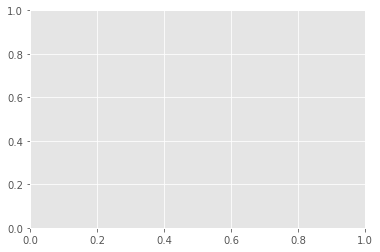

In [21]:
fig, ax = plt.subplots()
one_dim_scatterplot(pd_playlist_features["playlist_followers"], ax)
ax.set_xlim(0,25)

<AxesSubplot:xlabel='playlist_followers', ylabel='acousticness'>

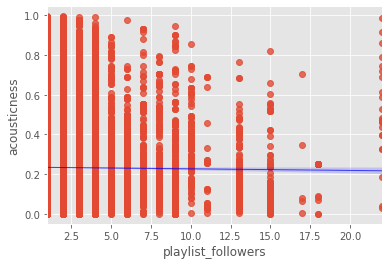

In [22]:
sns.regplot(x=pd_playlist_features_fixed["playlist_followers"], y=pd_playlist_features_fixed["acousticness"], line_kws={"color":"b","alpha":0.7,"lw":1})

## Creating, Saving and Reading artist_features_join dataset

In [23]:
artist_features_join = spark.sql("""
                                SELECT t.artist_name
                                ,AVG(a.acousticness) AS acousticness
                                ,AVG(a.danceability) AS danceability
                                ,AVG(a.energy) AS energy
                                ,AVG(a.instrumentalness) AS instrumentalness
                                ,AVG(a.liveness) AS liveness
                                ,AVG(a.loudness) AS loudness
                                ,AVG(a.speechiness) AS speechiness
                                ,AVG(a.tempo) AS avg_tempo
                                ,AVG(a.valence) AS valence
                                ,AVG(a.popularity) AS popularity
                                ,COUNT(DISTINCT t.track_name) AS unique_tracks_in_playlists
                                ,COUNT(ALL t.track_name) AS total_tracks_in_playlists
                                FROM tracks t
                                JOIN artist_features a
                                ON t.artist_name = a.artists
                                GROUP BY t.artist_name
                                ORDER BY t.artist_name ASC
                                """)

artist_features_join.show(15)

+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         artist_name|        acousticness|       danceability|             energy|    instrumentalness|           liveness|           loudness|         speechiness|         avg_tempo|            valence|        popularity|unique_tracks_in_playlists|total_tracks_in_playlists|
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         $uicideBoy$| 0.15463710144927542| 0.7785507246376814| 0.6258695652173915| 0.02472047565217391|0.20922318840579707| -6.553898550724632|  0.1499855072463768|117.

In [24]:
af_join = artist_features_join.toPandas()
print(af_join.info())
af_join.to_csv('/home/jovyan/work/Documents/dsi/Capstone1/data/artist_features_join.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   artist_name                 4787 non-null   object 
 1   acousticness                4787 non-null   float64
 2   danceability                4787 non-null   float64
 3   energy                      4787 non-null   float64
 4   instrumentalness            4787 non-null   float64
 5   liveness                    4787 non-null   float64
 6   loudness                    4787 non-null   float64
 7   speechiness                 4787 non-null   float64
 8   avg_tempo                   4787 non-null   float64
 9   valence                     4787 non-null   float64
 10  popularity                  4787 non-null   float64
 11  unique_tracks_in_playlists  4787 non-null   int64  
 12  total_tracks_in_playlists   4787 non-null   int64  
dtypes: float64(10), int64(2), object(

In [25]:
df_feature_join = spark.read.csv('/home/jovyan/work/Documents/dsi/Capstone1/data/artist_features_join.csv',header=True).cache()
df_feature_join.printSchema()
print("line count: {}".format(df_feature_join.count()))
df_feature_join.show()

root
 |-- artist_name: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- avg_tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- unique_tracks_in_playlists: string (nullable = true)
 |-- total_tracks_in_playlists: string (nullable = true)

line count: 4787
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         artist_name|        acousticness|       danceability|             energy|    instrumentalness|           liveness

In [1]:
pd_feature_join = df_feature_join.toPandas()
ints = list(pd_feature_join.columns)
ints = ints[1:]
pd_feature_join[ints] = pd_feature_join[ints].apply(pd.to_numeric)
pd_feature_join['artist_name'] = pd_feature_join['artist_name'].apply(lambda x: fr'{x}')
pd_feature_join = pd_feature_join.convert_dtypes()
sorted_feature_join = pd_feature_join.sort_values('total_tracks_in_playlists',ascending=False)
top_s = sorted_feature_join.loc[:,['artist_name','acousticness','danceability','energy','valence','avg_tempo','popularity','total_tracks_in_playlists']].copy()
top_s.head()


NameError: name 'df_feature_join' is not defined

In [27]:
top_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4787 entries, 1220 to 4786
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist_name                4787 non-null   string 
 1   acousticness               4787 non-null   Float64
 2   danceability               4787 non-null   Float64
 3   energy                     4787 non-null   Float64
 4   valence                    4787 non-null   Float64
 5   avg_tempo                  4787 non-null   Float64
 6   popularity                 4787 non-null   Float64
 7   total_tracks_in_playlists  4787 non-null   Int64  
dtypes: Float64(6), Int64(1), string(1)
memory usage: 369.3 KB


In [2]:
bars = list(top_s.columns)[1:5]

colors = ['red','blue','orange','purple','gray','green','brown','teal','yellow']
fig, ax = plt.subplots(3,3,figsize=(18,12))
for idx, axs in enumerate(ax.flatten()):
    heights = np.array(top_s.iloc[idx,1:5])
    axs.bar(bars,heights,color=colors[idx],edgecolor="black",alpha=.7)
    axs.set_title(top_s.iloc[idx,0])

NameError: name 'top_s' is not defined

In [40]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    ## why jitter? especially for bootstraping later
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([0, 1])
    ax.tick_params(axis='both', which='major', labelsize=25)

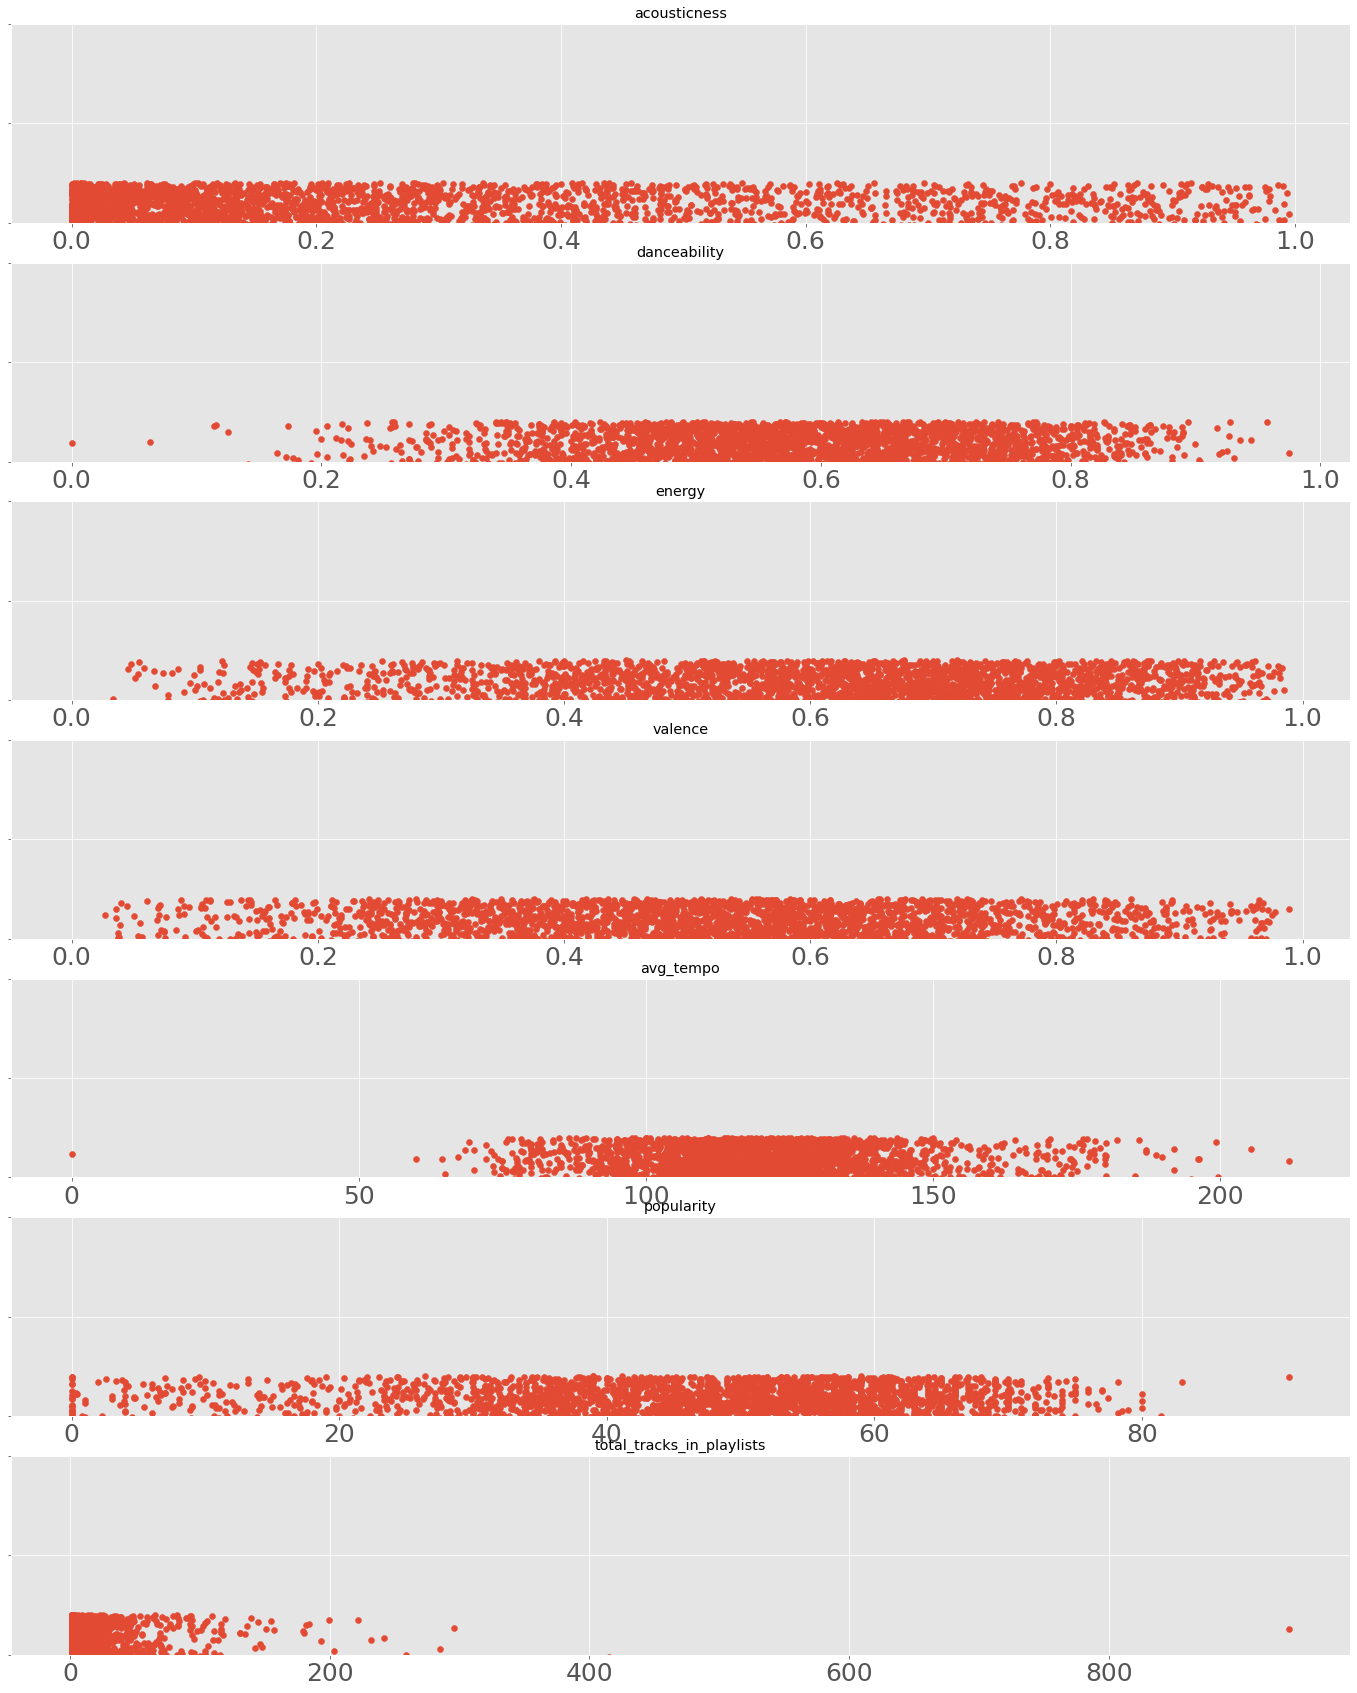

In [41]:
labels = list(top_s.columns)[1:]
fig, ax = plt.subplots(7,1, figsize=(24, 30))
for idx, axs in enumerate(ax.flatten()):
    feature = np.array(top_s.iloc[:,idx+1])
    one_dim_scatterplot(feature, axs)
    axs.set_title(labels[idx])

In [31]:
violin_data = top_s.iloc[:,1:5]
violin_data.head()


,acousticness,danceability,energy,valence
1220,0.190538,0.674018,0.577266,0.391614
2236,0.205292,0.600863,0.649066,0.454581
2279,0.215335,0.641123,0.682574,0.464895
3464,0.154517,0.653338,0.693772,0.514159
1341,0.137215,0.734854,0.7453,0.565777


<AxesSubplot:>

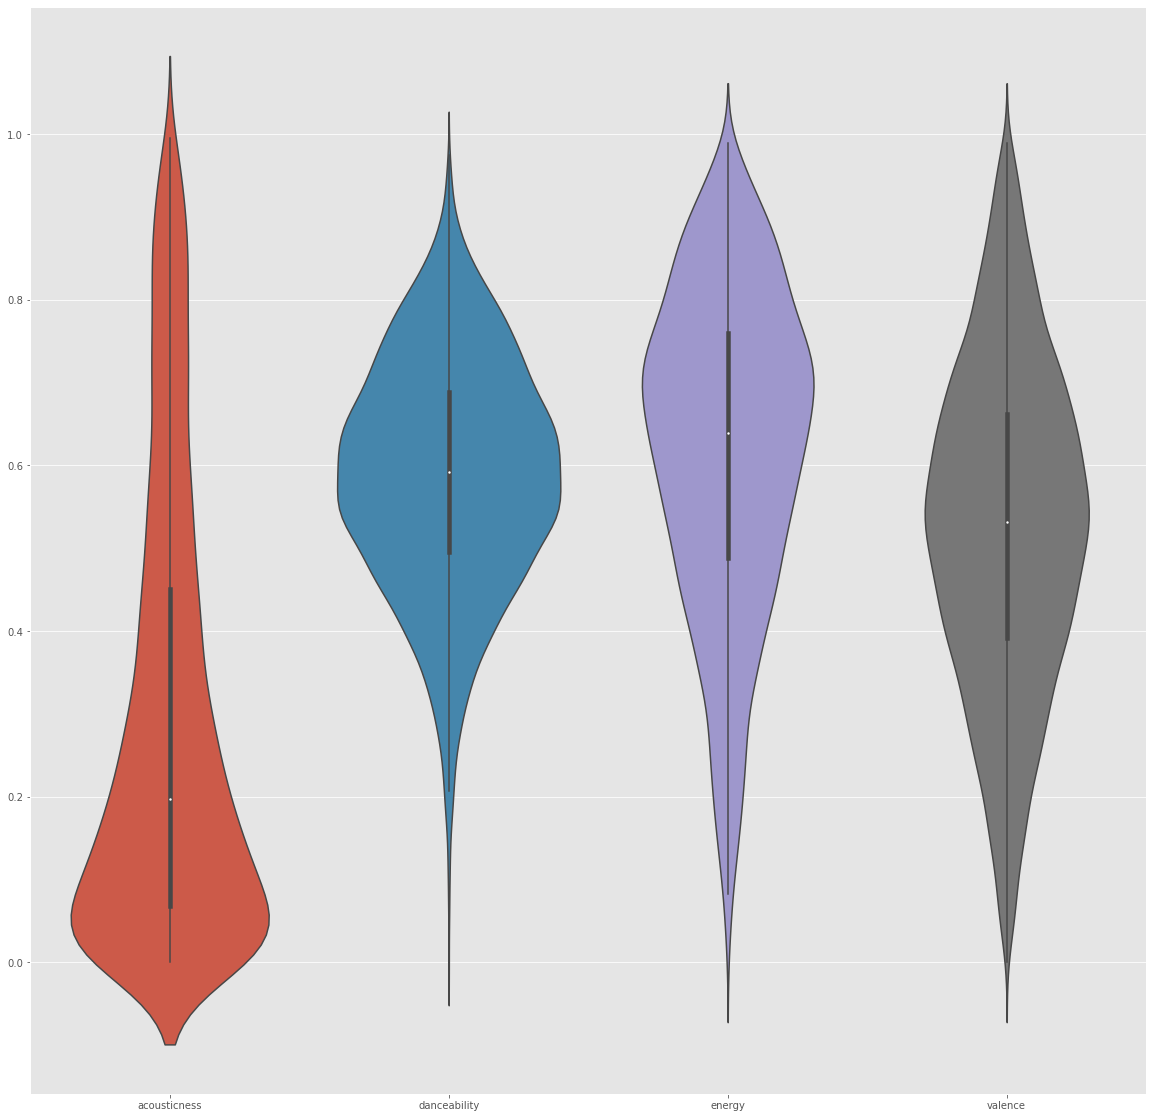

In [32]:
fig, ax = plt.subplots(figsize=(20,20))
sns.violinplot(data=violin_data, ax=ax)

<AxesSubplot:>

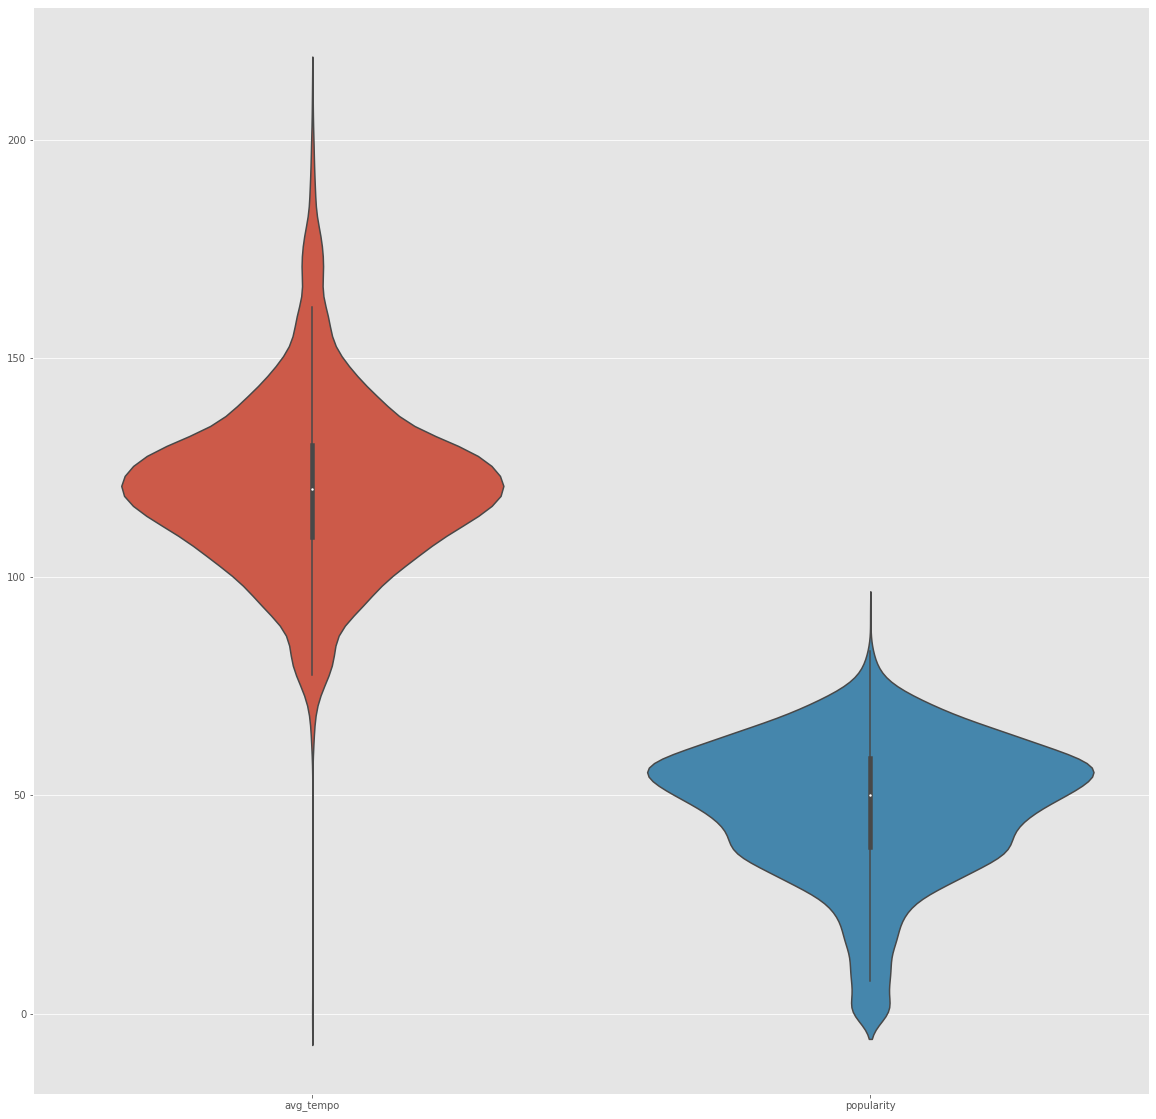

In [33]:
violin_data2 = top_s.iloc[:,5:7]
violin_data2.head()
fig, ax = plt.subplots(figsize=(20,20))
sns.violinplot(data=violin_data2, ax=ax)

In [34]:
#df_feature_join1 = df_feature_join.withColumn("popularity",F.col("popularity").cast("FloatType"))
df_feature_join.printSchema()
df_feature_join.createOrReplaceTempView("feature_join")

root
 |-- artist_name: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- avg_tempo: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- unique_tracks_in_playlists: string (nullable = true)
 |-- total_tracks_in_playlists: string (nullable = true)



In [35]:
select = spark.sql("""
                    SELECT *
                    FROM feature_join
                    WHERE artist_name LIKE '%%';
                    """)
select.show()

+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         artist_name|        acousticness|       danceability|             energy|    instrumentalness|           liveness|           loudness|         speechiness|         avg_tempo|            valence|        popularity|unique_tracks_in_playlists|total_tracks_in_playlists|
+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+--------------------------+-------------------------+
|         $uicideBoy$| 0.15463710144927542| 0.7785507246376814| 0.6258695652173915| 0.02472047565217391|0.20922318840579707| -6.553898550724632|  0.1499855072463768|117.